<a href="https://colab.research.google.com/github/Ayman947/HR-LogisticRegression-PredictingAbsenteeism/blob/main/2_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Employees Absenteeism Probability**

## **Importing Libraries**

In [88]:
# importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import pickle

# create the Custom Scaler class to only scale predetermined columns

class CustomScaler(BaseEstimator,TransformerMixin): 
    
    # init or what information we need to declare a CustomScaler object
    # and what is calculated/declared as we do
    
    def __init__(self,columns,copy=True,with_mean=True,with_std=True):
        
        # scaler is nothing but a Standard Scaler object
        self.scaler = StandardScaler(copy,with_mean,with_std)
        # with some columns 'twist'
        self.columns = columns
        self.mean_ = None
        self.var_ = None
        
    
    # the fit method, which, again based on StandardScale
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self
    
    # the transform method which does the actual scaling

    def transform(self, X, y=None, copy=None):
        
        # record the initial order of the columns
        init_col_order = X.columns
        
        # scale all features that you chose when creating the instance of the class
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        
        # declare a variable containing all information that was not scaled
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)]
        
        # return a data frame which contains all scaled features and all 'not scaled' features
        # use the original order (that you recorded in the beginning)
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

## **Data Gathering**

In [89]:
# importing our data 
raw_csv_data = pd.read_csv("1_absenteeism_data.csv")

# making a copy of our data
df = raw_csv_data.copy()
df.head()

,ID,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,11,26,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,36,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,3,23,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,7,7,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,11,23,23/07/2015,289,36,33,239.554,30,1,2,1,2


## **Data Cleansning & Preprocessing**

In [90]:
## Dealing with uneeded columns


# dropping the ID column
df = df.drop(['ID'], axis = 1)
df.head()

,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,26,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,23,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,7,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,23,23/07/2015,289,36,33,239.554,30,1,2,1,2


In [91]:
## Getting dummies of Absemce reasons column


# getting dummies for the absence reasons column
reason_columns = pd.get_dummies(df['Reason for Absence'], drop_first = True)

# dropping the reasons columns as it will be uneeded going forward
df = df.drop(['Reason for Absence'], axis = 1)

# grouping the reasons to reduce the no. of unique reasons
reason_type_1 = reason_columns.loc[:, 1:14].max(axis=1)
reason_type_2 = reason_columns.loc[:, 15:17].max(axis=1)
reason_type_3 = reason_columns.loc[:, 18:21].max(axis=1)
reason_type_4 = reason_columns.loc[:, 22:].max(axis=1)


# concatenating the reason columns into our dataframe
df = pd.concat([df, reason_type_1, reason_type_2, reason_type_3, reason_type_4], axis = 1)
df.sample(5)

,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,0,1,2,3
341,05/12/2016,179,51,38,236.629,31,1,0,0,1,0,0,0,1
337,29/11/2016,279,5,39,284.031,24,1,2,0,0,0,0,0,0
192,07/04/2016,118,13,50,326.452,31,1,1,0,1,0,0,0,1
398,20/03/2017,179,51,38,244.387,31,1,0,0,16,0,0,0,1
95,10/11/2015,225,26,28,306.345,24,1,1,2,3,0,0,0,1


In [92]:
## Renaming columns


# df.columns.values
df.columns = ['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 'Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']

# Viewing top columns
df.head()

,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Reason_1,Reason_2,Reason_3,Reason_4
0,07/07/2015,289,36,33,239.554,30,1,2,1,4,0,0,0,1
1,14/07/2015,118,13,50,239.554,31,1,1,0,0,0,0,0,0
2,15/07/2015,179,51,38,239.554,31,1,0,0,2,0,0,0,1
3,16/07/2015,279,5,39,239.554,24,1,2,0,4,1,0,0,0
4,23/07/2015,289,36,33,239.554,30,1,2,1,2,0,0,0,1


In [93]:
## Reordering columns



# df.columns.values
column_names_reordered = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 
                          'Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours']

df = df[column_names_reordered]

# Checkpoint_1
df_reason_mod = df

# viewing the top columns
df.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,0,0,0,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,0,0,0,1,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,1,0,0,0,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,0,0,0,1,23/07/2015,289,36,33,239.554,30,1,2,1,2


In [94]:
## Data Types


# type(df_reason_mod['Date'][0])
df_reason_mod['Date'] = pd.to_datetime(df_reason_mod['Date'])

# df_reason_mod.info()

In [95]:
## Extracting months


df_reason_mod['Month'] = df_reason_mod['Date'].apply(lambda x: x.month)
df_reason_mod.head(5)

,Reason_1,Reason_2,Reason_3,Reason_4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Month
0,0,0,0,1,2015-07-07,289,36,33,239.554,30,1,2,1,4,7
1,0,0,0,0,2015-07-14,118,13,50,239.554,31,1,1,0,0,7
2,0,0,0,1,2015-07-15,179,51,38,239.554,31,1,0,0,2,7
3,1,0,0,0,2015-07-16,279,5,39,239.554,24,1,2,0,4,7
4,0,0,0,1,2015-07-23,289,36,33,239.554,30,1,2,1,2,7


In [96]:
## Extracting day of week


df_reason_mod['Day of the Week'] = df_reason_mod['Date'].apply(lambda x: x.weekday())
df_reason_mod.head(5)

,Reason_1,Reason_2,Reason_3,Reason_4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Month,Day of the Week
0,0,0,0,1,2015-07-07,289,36,33,239.554,30,1,2,1,4,7,1
1,0,0,0,0,2015-07-14,118,13,50,239.554,31,1,1,0,0,7,1
2,0,0,0,1,2015-07-15,179,51,38,239.554,31,1,0,0,2,7,2
3,1,0,0,0,2015-07-16,279,5,39,239.554,24,1,2,0,4,7,3
4,0,0,0,1,2015-07-23,289,36,33,239.554,30,1,2,1,2,7,3


In [97]:
## Reordering columns


column_names_upd = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Month', 'Day of the Week',
       'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education', 'Children',
       'Pets', 'Absenteeism Time in Hours']

df_reason_date_mod = df_reason_mod[column_names_upd]
df_reason_date_mod.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,1,289,36,33,239.554,30,1,2,1,4
1,0,0,0,0,7,1,118,13,50,239.554,31,1,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,1,0,0,2
3,1,0,0,0,7,3,279,5,39,239.554,24,1,2,0,4
4,0,0,0,1,7,3,289,36,33,239.554,30,1,2,1,2


In [98]:
## Education Column


# df_reason_date_mod['Education'].unique()
# df_reason_date_mod['Education'].value_counts()
df_reason_date_mod['Education'] = df_reason_date_mod['Education'].map({1:0, 2:1, 3:1, 4:1})
df_reason_date_mod['Education'].unique()

# Checkpoint_2 
data_preprocessed = df_reason_date_mod.copy()
data_preprocessed.drop(['Daily Work Load Average', 'Distance to Work', 'Day of the Week'], axis = 1, inplace=True)
data_preprocessed.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Reason_1,Reason_2,Reason_3,Reason_4,Month,Transportation Expense,Age,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,289,33,30,0,2,1,4
1,0,0,0,0,7,118,50,31,0,1,0,0
2,0,0,0,1,7,179,38,31,0,0,0,2
3,1,0,0,0,7,279,39,24,0,2,0,4
4,0,0,0,1,7,289,33,30,0,2,1,2
5,0,0,0,1,10,179,38,31,0,0,0,2
6,0,0,0,1,7,361,28,27,0,1,4,8
7,0,0,0,1,7,260,36,23,0,4,0,4
8,0,0,1,0,6,155,34,25,0,2,0,40
9,0,0,0,1,7,235,37,29,1,1,1,8


## **Modelling**

#### Creating The Target

In [99]:
# find the median of 'Absenteeism Time in Hours'
data_preprocessed['Absenteeism Time in Hours'].median()

3.0

In [100]:
# Mapping the target into 2 variavbles according to the median
targets = np.where(data_preprocessed['Absenteeism Time in Hours'] > 
                   data_preprocessed['Absenteeism Time in Hours'].median(), 1, 0)

In [101]:
# create a Series in the original data frame that will contain the targets for the regression
data_preprocessed['Excessive Absenteeism'] = targets
data_preprocessed.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month,Transportation Expense,Age,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Excessive Absenteeism
0,0,0,0,1,7,289,33,30,0,2,1,4,1
1,0,0,0,0,7,118,50,31,0,1,0,0,0
2,0,0,0,1,7,179,38,31,0,0,0,2,0
3,1,0,0,0,7,279,39,24,0,2,0,4,1
4,0,0,0,1,7,289,33,30,0,2,1,2,0


In [102]:
# create a checkpoint by dropping the unnecessary variables
data_with_targets = data_preprocessed.drop(['Absenteeism Time in Hours'],axis=1)
data_with_targets.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Month,Transportation Expense,Age,Body Mass Index,Education,Children,Pets,Excessive Absenteeism
0,0,0,0,1,7,289,33,30,0,2,1,1
1,0,0,0,0,7,118,50,31,0,1,0,0
2,0,0,0,1,7,179,38,31,0,0,0,0
3,1,0,0,0,7,279,39,24,0,2,0,1
4,0,0,0,1,7,289,33,30,0,2,1,0


#### Creating & Scaling Inputs

In [103]:
# create a variable that will contain the inputs (everything without the targets)
unscaled_inputs = data_with_targets.iloc[:,:-1]
# unscaled_inputs

In [104]:
# define scaler as an object
absenteeism_scaler = StandardScaler()

# selecting the columns to omit
columns_to_omit = ['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4','Education']

# creating the columns to scale, based on the columns to omit
columns_to_scale = [x for x in unscaled_inputs.columns.values if x not in columns_to_omit]

# declaring a scaler object, specifying the columns you want to scale
absenteeism_scaler = CustomScaler(columns_to_scale)

# fitting the scaler using data 
absenteeism_scaler.fit(unscaled_inputs)

# Transforming the data using the previously defined scaler 
scaled_inputs = absenteeism_scaler.transform(unscaled_inputs)

In [105]:
# check the shape of the inputs
# scaled_inputs.shape

# displaying the scaled
scaled_inputs

,Reason_1,Reason_2,Reason_3,Reason_4,Month,Transportation Expense,Age,Body Mass Index,Education,Children,Pets
0,0,0,0,1,0.030796,1.005844,-0.536062,0.767431,0,0.880469,0.268487
1,0,0,0,0,0.030796,-1.574681,2.130803,1.002633,0,-0.019280,-0.589690
2,0,0,0,1,0.030796,-0.654143,0.248310,1.002633,0,-0.919030,-0.589690
3,1,0,0,0,0.030796,0.854936,0.405184,-0.643782,0,0.880469,-0.589690
4,0,0,0,1,0.030796,1.005844,-0.536062,0.767431,0,0.880469,0.268487
...,...,...,...,...,...,...,...,...,...,...,...
695,1,0,0,0,-0.568019,-0.654143,0.562059,-1.114186,1,0.880469,-0.589690
696,1,0,0,0,-0.568019,0.040034,-1.320435,-0.643782,0,-0.019280,1.126663
697,1,0,0,0,-0.568019,1.624567,-1.320435,-0.408580,1,-0.919030,-0.589690
698,0,0,0,1,-0.568019,0.190942,-0.692937,-0.408580,1,-0.919030,-0.589690


#### Train Test Split

In [106]:
# splitting the data into 80 20 datasets
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size = 0.2, random_state = 20)

# check the shape of the train inputs and targets
print (x_train.shape, y_train.shape)

# check the shape of the test inputs and targets
print (x_test.shape, y_test.shape)

(560, 11) (560,)
(140, 11) (140,)


#### Training 

In [107]:
# creating a logistic regression object
reg = LogisticRegression()

# fitting our train inputs
reg.fit(x_train,y_train)

# getting the train accuracy of the model
print(f'The model accuracy = {round(reg.score(x_train,y_train)*100, 2)} %')

The model accuracy = 77.68 %


#### Interpretaion

In [108]:
# Making numpy print numbers with higher precision (i.e accurate numbers not approximate)
np.set_printoptions(suppress=True, linewidth=100, precision=5)
# Printing the intercept
# LR.intercept_
# Printing the coefficients
# LR.coef_

# Printing the input columns
input_names = scaled_inputs.columns.values
# input_names

# Creating a data frame illustrating inputs and their respective coefficients
df_summary = pd.DataFrame( data = {'Inputs' : np.append(input_names,'Intercept'),
                                   'Coefficients' : np.append(np.transpose(np.squeeze(reg.coef_)),reg.intercept_)})

# Adding Odds_ratio to intercept the coefficients
df_summary['Odds_ratio'] = np.exp(df_summary.Coefficients)

# Sorting the dataframe by odd_ration
df_summary.sort_values('Odds_ratio', ascending=False, inplace=True)

# Exporting the dataframe into a csv file
df_summary.to_csv('Model-Summary.csv')

# Viewing the dataframe
df_summary

,Inputs,Coefficients,Odds_ratio
2,Reason_3,3.092102,22.023327
0,Reason_1,2.771512,15.982778
1,Reason_2,0.931688,2.538791
3,Reason_4,0.809059,2.245794
5,Transportation Expense,0.625055,1.868348
9,Children,0.357535,1.429801
7,Body Mass Index,0.288294,1.334150
4,Month,0.007812,1.007843
6,Age,-0.173903,0.840378
8,Education,-0.240816,0.785986


> For every unit increase in a standardized input, the liklehood of occurence increases by a multiple equal to the "odds_ratio" amount, keeping other variables constant.

In [109]:
# Filtering the dataframe to get low predictability inputs
low_bound  = 0.85 
high_bound = 1.0001
df_filtered = df_summary[df_summary['Odds_ratio'] > low_bound]
df_filtered = df_filtered[df_filtered['Odds_ratio'] < high_bound]

# Printing the low predictability variables
print('**The inputs we need to exclude or Back Eliminate**\n')
for i in df_filtered.Inputs:
  if i != 'Intercept':
    if len(i)>0:
      print(i)

**The inputs we need to exclude or Back Eliminate**



#### Testing

In [110]:
# Predicting using the test data by the model
yhat = reg.predict(x_test)
# yhat

# Getting the outputs probabilities
yhat_prob = reg.predict_proba(x_test)
# yhat_prob

In [111]:
## Overall Accuarcy

# Printing the test accuracy
print(f'The test accuracy = {round(reg.score(x_test, y_test)*100, 2)} %\n(i.e For every 100 predictions, there are nearly {int(round(reg.score(x_test, y_test)*100, 0))} are true.')

The test accuracy = 73.57 %
(i.e For every 100 predictions, there are nearly 74 are true.


In [112]:
## F1-Score

# Harmonic metric combining both accuracy and precision
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        74
           1       0.75      0.67      0.70        66

    accuracy                           0.74       140
   macro avg       0.74      0.73      0.73       140
weighted avg       0.74      0.74      0.73       140



Normalized confusion matrix
[[0.67 0.33]
 [0.2  0.8 ]]


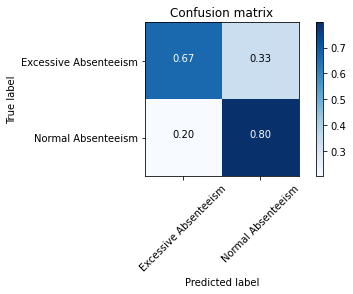

In [113]:
  ## Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Excessive Absenteeism','Normal Absenteeism'],normalize= True,  title='Confusion matrix')

## **Pickling**

In [114]:
# Converting the objects into a character streams

with open('reg', 'wb') as file:
  pickle.dump(reg, file)
  file.close()
  

with open('scaler', 'wb') as file_2:
  pickle.dump(absenteeism_scaler, file_2)
  file_2.close()  